# CS:GO Round Winner Classification

### About CS:GO

CS:GO is a tactical shooter, where two teams (CT and Terrorist) play for a best of 30 rounds, with each round being 1 minute and 55 seconds. There are 5 players on each team (10 in total) and the first team to reach 16 rounds wins the game. At the start, one team plays as CT and the other as Terrorist. After 15 rounds played, the teams swap side. There are 7 different maps a game can be played on. You win a round as Terrorist by either planting the bomb and making sure it explodes, or by eliminating the other team. You win a round as CT by either eliminating the other team, or by disarming the bomb, should it have been planted.

### About dataset

The dataset was originally published by Skybox as part of their CS:GO AI Challenge, running from Spring to Fall 2020. The data set consists of ~700 demos from high level tournament play in 2019 and 2020. Warmup rounds and restarts have been filtered, and for the remaining live rounds a round snapshot have been recorded every 20 seconds until the round is decided. Following the initial publication, It has been pre-processed and flattened to improve readability and make it easier for algorithms to process. The total number of snapshots is 122411.

Skybox website: https://skybox.gg/

Learn more about CS:GO: https://en.wikipedia.org/wiki/Counter-Strike:_Global_Offensive

View CS:GO on Steam Store: https://store.steampowered.com/app/730/CounterStrike_Global_Offensive/

Find in-depth information on competitive CS:GO: https://www.hltv.org/

| Variable         | Definition                                                            | Key                                                                     |
|------------------|-----------------------------------------------------------------------|-------------------------------------------------------------------------|
| time_left        | The time left in the current round.                                   |                                                                         |
| ct_score         | The current score of the Counter-Terrorist team.                      |                                                                         |
| t_score          | The current score of the Terrorist team.                              |                                                                         |
| map              | The map the round is being played on.                                  | E.g. de_dust2, de_inferno and de_overpass                                |
| bomb_planted     | If the bomb has been planted or not.                                   | False = No, True = Yes                                                 |
| ct_health        | The total health of all Counter-Terrorist players.                    | Player health in range 0-100.                                           |
| t_health         | The total health of all Terrorist players.                             | Player health in range 0-100.                                           |
| ct_armor         | The total armor of all Counter-Terrorist players.                      |                                                                         |
| t_armor          | The total armor of all Terrorist players.                              |                                                                         |
| ct_money         | The total bankroll of all Counter-Terrorist players.                   | Amount in USD.                                                          |
| t_money          | The total bankroll of all Terrorist players.                           | Amount in USD.                                                          |
| ct_helmets       | Number of helmets on the Counter-Terrorist team.                       |                                                                         |
| t_helmets        | Number of helmets on the Terrorist team.                               |                                                                         |
| ct_defuse_kits   | Number of defuse kits on the Counter-Terrorist team.                   |                                                                         |
| ct_players_alive | Number of alive players on the Counter-Terrorist team.                 | Range 0 to 5.                                                           |
| t_players_alive  | Number of alive players on the Terrorist team.                         | Range 0 to 5.                                                           |
| ct_weapon_X      | Weapon X count on Counter-Terrorist team.                              | E.g. Ak47, Deagle and UMP45.                                             |
| t_weapon_X       | Weapon X count on Terrorist team.                                      | E.g. Ak47, Deagle and UMP45.                                             |
| ct_grenade_X     | Grenade X count on Counter-Terrorist team.                             | E.g. HeGrenade, Flashbang.                                               |
| t_grenade_X      | Grenade X count on Terrorist team.                                     | E.g. HeGrenade, Flashbang.                                               |
| round_winner     | Winner.                                                               | CT = Counter-Terrorist, T = Terrorist                                    |


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from keras.models import Sequential
from keras.layers import Dense

In [2]:
df = pd.read_csv('csgo_round_snapshots.csv')


In [3]:
maps = {'de_dust2': 0, 'de_mirage': 1, 'de_nuke': 2, 'de_inferno': 3, 'de_train': 4, 'de_overpass': 5, 'de_vertigo': 6}

df['map'] = df['map'].map(maps)

print(df.isnull().sum())

#delete rows with missing values
df = df.dropna()
print(df.shape)

time_left                      0
ct_score                       0
t_score                        0
map                          145
bomb_planted                   0
                            ... 
ct_grenade_molotovgrenade      0
t_grenade_molotovgrenade       0
ct_grenade_decoygrenade        0
t_grenade_decoygrenade         0
round_winner                   0
Length: 97, dtype: int64
(122265, 97)


<AxesSubplot:>

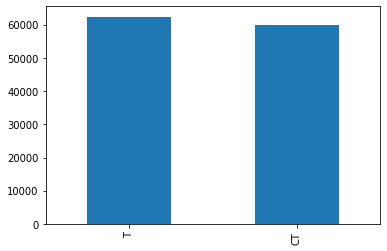

In [4]:
df['round_winner'].value_counts().plot.bar()

In [5]:
X = df.values[:, :-1]
y = df.values[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=278823)

[Text(0.23533789710525926, 0.9895833333333334, 'x[8] <= 100.5\ngini = 0.5\nsamples = 85585\nvalue = [42005, 43580]'),
 Text(0.08551719268717109, 0.96875, 'x[7] <= 110.5\ngini = 0.335\nsamples = 19865\nvalue = [15642, 4223]'),
 Text(0.04864575849922437, 0.9479166666666666, 'x[8] <= 15.5\ngini = 0.499\nsamples = 5163\nvalue = [2490, 2673]'),
 Text(0.03247470873029313, 0.9270833333333334, 'x[7] <= 70.5\ngini = 0.469\nsamples = 2901\nvalue = [1813, 1088]'),
 Text(0.026612283810392944, 0.90625, 'x[87] <= 0.5\ngini = 0.5\nsamples = 1703\nvalue = [862, 841]'),
 Text(0.023820358316268688, 0.8854166666666666, 'x[34] <= 0.5\ngini = 0.497\nsamples = 1505\nvalue = [694, 811]'),
 Text(0.023705833645170274, 0.8645833333333334, 'x[13] <= 0.5\ngini = 0.5\nsamples = 1433\nvalue = [694, 739]'),
 Text(0.019925746226721747, 0.84375, 'x[14] <= 4.5\ngini = 0.498\nsamples = 1356\nvalue = [634, 722]'),
 Text(0.017388010158863976, 0.8229166666666666, 'x[5] <= 64.5\ngini = 0.36\nsamples = 51\nvalue = [39, 12]')

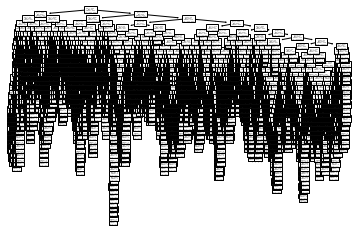

In [6]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

tree.plot_tree(clf)

In [7]:
clf.score(X_test, y_test)

0.8130588876772082

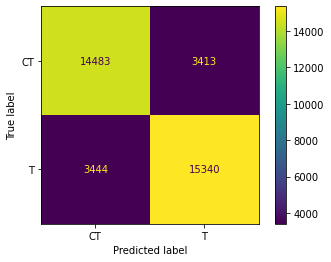

In [8]:
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

[Text(0.47771773182957394, 0.9444444444444444, 'x[8] <= 100.5\ngini = 0.5\nsamples = 85585\nvalue = [42005, 43580]'),
 Text(0.22979323308270677, 0.8333333333333334, 'x[7] <= 110.5\ngini = 0.335\nsamples = 19865\nvalue = [15642, 4223]'),
 Text(0.10823934837092732, 0.7222222222222222, 'x[8] <= 15.5\ngini = 0.499\nsamples = 5163\nvalue = [2490, 2673]'),
 Text(0.05294486215538847, 0.6111111111111112, 'x[7] <= 70.5\ngini = 0.469\nsamples = 2901\nvalue = [1813, 1088]'),
 Text(0.023182957393483708, 0.5, 'x[87] <= 0.5\ngini = 0.5\nsamples = 1703\nvalue = [862, 841]'),
 Text(0.012531328320802004, 0.3888888888888889, 'x[34] <= 0.5\ngini = 0.497\nsamples = 1505\nvalue = [694, 811]'),
 Text(0.010025062656641603, 0.2777777777777778, 'x[13] <= 0.5\ngini = 0.5\nsamples = 1433\nvalue = [694, 739]'),
 Text(0.005012531328320802, 0.16666666666666666, 'x[5] <= 450.0\ngini = 0.498\nsamples = 1356\nvalue = [634, 722]'),
 Text(0.002506265664160401, 0.05555555555555555, 'gini = 0.36\nsamples = 51\nvalue = [39

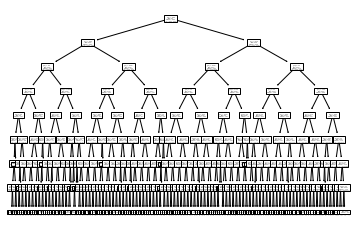

In [9]:
clf = tree.DecisionTreeClassifier(max_depth=8)
clf = clf.fit(X_train, y_train)

tree.plot_tree(clf)

In [10]:
clf.score(X_test, y_test)

0.7488276990185387

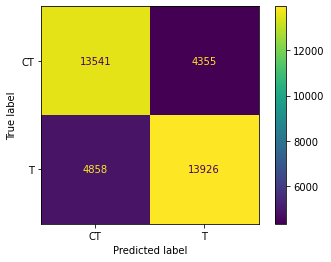

In [11]:
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [12]:
model = GaussianNB()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7287350054525628

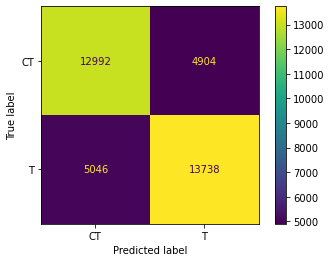

In [13]:
predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [14]:
knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.7695747001090513

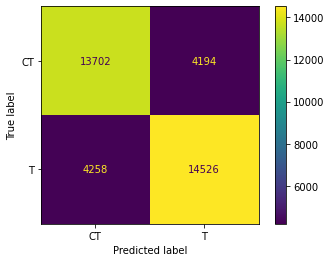

In [15]:
predictions = knn.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [16]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.7537622682660851

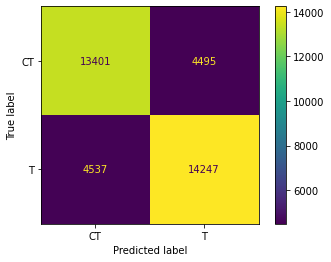

In [17]:
predictions = knn.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [18]:
knn = KNeighborsClassifier(n_neighbors=11, metric='euclidean')
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.7313794983642312

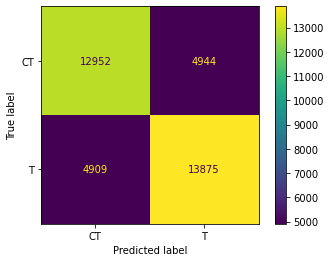

In [19]:
predictions = knn.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [27]:
# def round_winner_to_int(round_winner):
#     if round_winner == 'CT':
#         return 0
#     else:
#         return 1

# rwti = np.vectorize(round_winner_to_int)

# X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
# X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

# y_train = rwti(y_train)
# y_test = rwti(y_test)

In [4]:
df['round_winner'] = df['round_winner'].map({'CT': 0, 'T': 1})
df['bomb_planted'] = df['bomb_planted'].map({False: 0, True: 1})
df = df.dropna()

X = df.values[:, :-1]
y = df.values[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=278823)

X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [5]:
model = Sequential()
model.add(Dense(8, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [6]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
history = model.fit(X_train, y_train, epochs=250, verbose=0, validation_data=(X_test, y_test))

In [8]:
predictions_train = model.predict(X_train).round()
print(accuracy_score(predictions_train, y_train))

predictions_test = model.predict(X_test).round()
print(accuracy_score(predictions_test, y_test))

2675/2675 [==============================] - 4s 1ms/step
0.755225798913361
1147/1147 [==============================] - 1s 1ms/step
0.7460196292257361


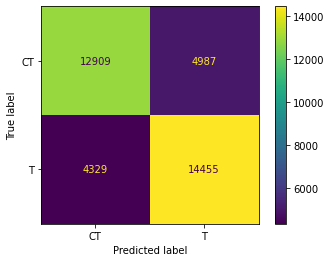

In [9]:
cm = confusion_matrix(y_test, predictions_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['CT', 'T'])
disp.plot()

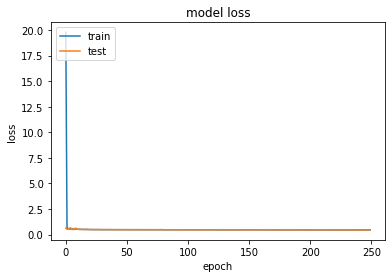

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [5]:
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [6]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
history = model.fit(X_train, y_train, epochs=250, verbose=0, validation_data=(X_test, y_test))

In [8]:
predictions_train = model.predict(X_train).round()
print(accuracy_score(predictions_train, y_train))

predictions_test = model.predict(X_test).round()
print(accuracy_score(predictions_test, y_test))

2675/2675 [==============================] - 2s 773us/step
0.7459835251504352
1147/1147 [==============================] - 1s 837us/step
0.7420937840785169


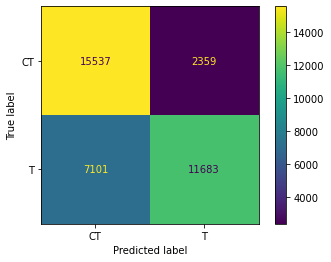

In [9]:
cm = confusion_matrix(y_test, predictions_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['CT', 'T'])
disp.plot()

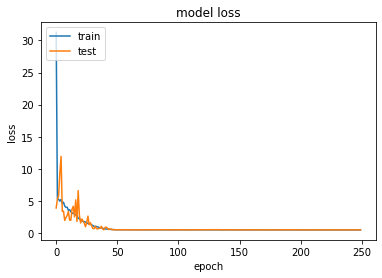

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [12]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
history = model.fit(X_train, y_train, epochs=250, verbose=0, validation_data=(X_test, y_test))

In [14]:
predictions_train = model.predict(X_train).round()
print(accuracy_score(predictions_train, y_train))

predictions_test = model.predict(X_test).round()
print(accuracy_score(predictions_test, y_test))

2675/2675 [==============================] - 3s 948us/step
0.7482970146637845
1147/1147 [==============================] - 1s 912us/step
0.7412486368593239


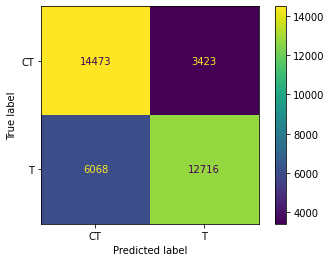

In [15]:
cm = confusion_matrix(y_test, predictions_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['CT', 'T'])
disp.plot()

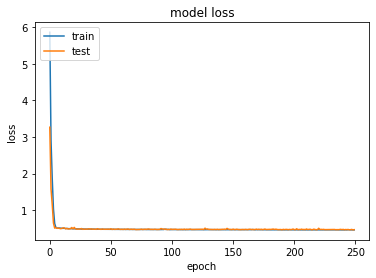

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()